In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from prepare_data import input_data, convert_to_dataset

### Building deep LSTM networks to classify EEG signals into seizure and free seizure segments.

In [ ]:
# load data
X_train, X_val, X_test, y_train, y_val, y_test = input_data(val=True)
train_ds = convert_to_dataset(X_train, y_train)
val_ds = convert_to_dataset(X_val, y_val)
test_ds = convert_to_dataset(X_test, y_test)

#### LSTM

In [ ]:
# build the model
input = Input((178, 1))
lstm = LSTM(64, dropout=0.1, recurrent_dropout=0.1)(input)
drop = Dropout(0.2)(lstm)
output = Dense(1, activation='sigmoid')(drop)
lstm_model = Model(input, output, name="lstm")
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 178, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
save_model_path = './models/checkpoint_LSTM.weights.h5'
checkpoint = ModelCheckpoint(filepath=save_model_path,
                             monitor='val_accuracy',
                             save_weights_only=True,
                             save_best_only=True)
csv_logger = CSVLogger('./logs/LSTM_Logger.log')

lstm_hist = lstm_model.fit(train_ds, epochs=100,
                            validation_data=val_ds,
                            callbacks=[checkpoint, csv_logger])

Epoch 1/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 49s 99ms/step - accuracy: 0.7774 - loss: 0.4740 - val_accuracy: 0.9366 - val_loss: 0.2068
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 84s 105ms/step - accuracy: 0.8962 - loss: 0.3064 - val_accuracy: 0.9378 - val_loss: 0.1908
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step - accuracy: 0.8756 - loss: 0.3605 - val_accuracy: 0.9499 - val_loss: 0.1778
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 80s 99ms/step - accuracy: 0.9077 - loss: 0.2767 - val_accuracy: 0.9668 - val_loss: 0.1449
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 82s 99ms/step - accuracy: 0.9042 - loss: 0.2804 - val_accuracy: 0.9601 - val_loss: 0.1500
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step - accuracy: 0.9063 - loss: 0.2726 - val_accuracy: 0.9372 - val_loss: 0.2123
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 81s 99ms/step - accuracy: 0.9048 - loss: 0.2841 - val_accuracy: 0.9722 - val_loss: 0.1350
Epoch 8/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 46s 100ms/step - accuracy: 0.9089 - los

In [ ]:
def print_accuracy(history, title):
    fig = plt.Figure()
    plt.plot(history.history['accuracy'], 'b-')
    plt.plot(history.history['val_accuracy'], 'r-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.grid(visible=True, which='both', color='gray', linestyle='-', linewidth=0.5)
    plt.show()

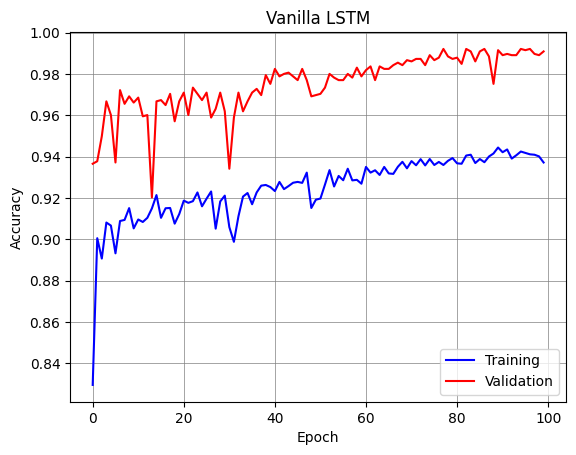

In [ ]:
print_accuracy(lstm_hist, "'Vanilla LSTM'")

Prediction

In [ ]:
lstm_model.load_weights('./models/checkpoint_LSTM.weights.h5')
_, acc = lstm_model.evaluate(test_ds, verbose=2)
print(f"Test accuracy = {100 * acc:.2f}%")

58/58 - 2s - 33ms/step - accuracy: 0.9832 - loss: 0.0504
Test accuracy = 98.32%


#### Stacked LSTM

In [ ]:
# build the model
input = Input((178, 1))
lstm1 = LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)(input)
drop1 = Dropout(0.2)(lstm1)
lstm2 = LSTM(64, dropout=0.1, recurrent_dropout=0.1)(drop1)
drop2 = Dropout(0.2)(lstm2)
output = Dense(1, activation='sigmoid')(drop2)
stack_lstm_model = Model(input, output, name="stacked_lstm")
stack_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
stack_lstm_model.summary()

Model: "stacked_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 178, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 178, 64)             │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 178, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
save_model_path = './models/checkpoint_stackLSTM.weights.h5'
checkpoint = ModelCheckpoint(filepath=save_model_path,
                             monitor='val_accuracy',
                             save_weights_only=True,
                             save_best_only=True)
csv_logger = CSVLogger('./logs/stackLSTM_Logger.log')

stack_lstm_hist = stack_lstm_model.fit(train_ds, epochs=100,
                            validation_data=val_ds,
                            callbacks=[checkpoint, csv_logger])

Epoch 1/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 86s 177ms/step - accuracy: 0.8575 - loss: 0.3755 - val_accuracy: 0.9312 - val_loss: 0.2014
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 143s 179ms/step - accuracy: 0.8782 - loss: 0.3347 - val_accuracy: 0.9149 - val_loss: 0.2540
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 84s 181ms/step - accuracy: 0.8886 - loss: 0.3045 - val_accuracy: 0.9275 - val_loss: 0.2423
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 83s 179ms/step - accuracy: 0.8853 - loss: 0.3313 - val_accuracy: 0.9293 - val_loss: 0.2137
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 82s 177ms/step - accuracy: 0.8995 - loss: 0.2921 - val_accuracy: 0.9764 - val_loss: 0.1250
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 144s 182ms/step - accuracy: 0.9113 - loss: 0.2552 - val_accuracy: 0.9269 - val_loss: 0.1951
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 141s 181ms/step - accuracy: 0.8935 - loss: 0.2708 - val_accuracy: 0.9656 - val_loss: 0.1088
Epoch 8/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 88s 189ms/step - accuracy: 0.913

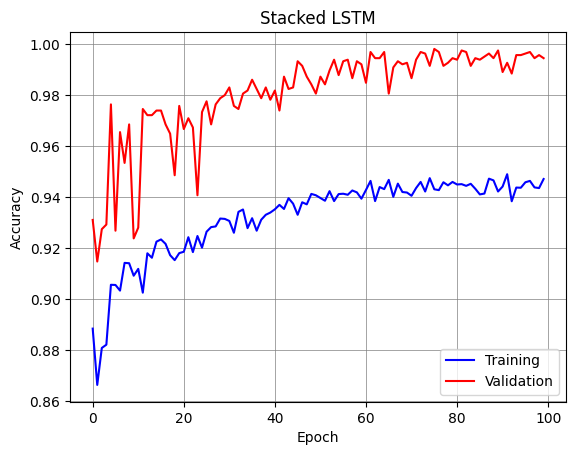

In [ ]:
print_accuracy(stack_lstm_hist, 'Stacked LSTM')

In [ ]:
stack_lstm_model.load_weights('./models/checkpoint_stackLSTM.weights.h5')
_, acc = stack_lstm_model.evaluate(test_ds, verbose=2)
print(f"Test accuracy = {100 * acc:.2f}%")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


58/58 - 5s - 89ms/step - accuracy: 0.9978 - loss: 0.0074
Test accuracy = 99.78%


#### Bidirectional LSTM

In [ ]:
# build the model
input = Input((178, 1))
bi_lstm = Bidirectional(LSTM(units=64, dropout=0.1, recurrent_dropout=0.1))(input)
drop = Dropout(0.2)(bi_lstm)
output = Dense(1, activation='sigmoid')(drop)
bi_lstm_model = Model(input, output, name="bi_lstm")
bi_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_lstm_model.summary()

Model: "bi_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 178, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,921 (132.50 KB)

 Trainable params: 33,921 (132.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
save_model_path = './models/checkpoint_biLSTM.weights.h5'
checkpoint = ModelCheckpoint(filepath=save_model_path,
                             monitor='val_accuracy',
                             save_weights_only=True,
                             save_best_only=True)
csv_logger = CSVLogger('./logs/biLSTM_Logger.log')

bi_lstm_hist = bi_lstm_model.fit(train_ds, epochs=100,
                            validation_data=val_ds,
                            callbacks=[checkpoint, csv_logger])

Epoch 1/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 68s 138ms/step - accuracy: 0.8217 - loss: 0.3840 - val_accuracy: 0.9469 - val_loss: 0.1663
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - accuracy: 0.9156 - loss: 0.2309 - val_accuracy: 0.9064 - val_loss: 0.2311
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 63s 135ms/step - accuracy: 0.8937 - loss: 0.2818 - val_accuracy: 0.9390 - val_loss: 0.1843
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 82s 136ms/step - accuracy: 0.9132 - loss: 0.2606 - val_accuracy: 0.9257 - val_loss: 0.2810
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 84s 140ms/step - accuracy: 0.8922 - loss: 0.3025 - val_accuracy: 0.9529 - val_loss: 0.1783
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 80s 137ms/step - accuracy: 0.9111 - loss: 0.2632 - val_accuracy: 0.9650 - val_loss: 0.1357
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - accuracy: 0.9134 - loss: 0.2522 - val_accuracy: 0.9577 - val_loss: 0.1460
Epoch 8/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 65s 138ms/step - accuracy: 0.9185 -

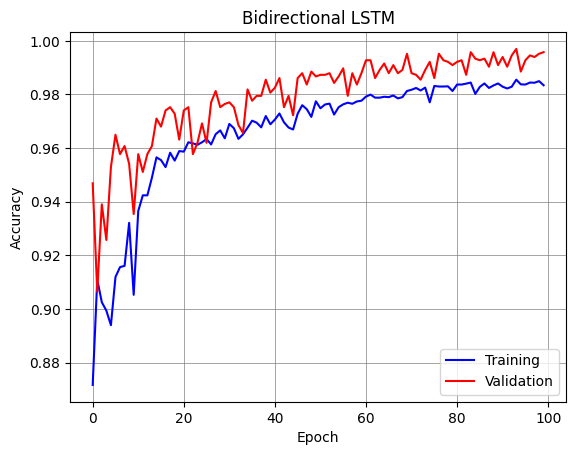

In [ ]:
print_accuracy(bi_lstm_hist, 'Bidirectional LSTM')

In [ ]:
bi_lstm_model.load_weights('./models/checkpoint_biLSTM.weights.h5')
_, acc = bi_lstm_model.evaluate(test_ds, verbose=2)
print(f"Test accuracy = {100 * acc:.2f}%")

58/58 - 2s - 27ms/step - accuracy: 0.9935 - loss: 0.0215
Test accuracy = 99.35%
